In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from scripts.data import *
import numpy as np
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
import torch
from scripts.nn import *
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar
from matplotlib import pyplot as plt
plt.style.use('plot.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
struct_type = 'atomistic'
hypers_type = struct_type
numb_train = None
l_max = 8
energy_type = "e_local_mofff"

In [3]:
all_rattled_batches = [2, 3, 4, 5]
energy_cutoff = 1

In [4]:
complete_cg_df, complete_a_df = get_complete_dataframes(energy_cutoff=energy_cutoff)

In [5]:
complete_cg_df = complete_cg_df.xs('small',level=1)
complete_a_df = complete_a_df.xs('small',level=1)

In [6]:
soap_cutoff, atom_sigma, noise = get_opt_hypers(hypers_type)
desc = build_soap_descriptor(struct_type, soap_cutoff, atom_sigma,l_max)

print(f"SOAP cutoff: {soap_cutoff}; SOAP sigma: {atom_sigma}; noise: {noise}")

# set the B_site flag and the atomistic dataframe if needed
if struct_type == "cg":
    B_site = True
    a_df = None
elif struct_type == "A_cg":
    B_site = False
    a_df = None
else:
    B_site = True
    a_df = complete_a_df

SOAP cutoff: 6.75; SOAP sigma: 0.5; noise: 0.2


In [7]:
fold_ids = get_fold_ids(complete_cg_df, 5)
k = len(fold_ids)

train_rmses = []
test_rmses = []
all_train_predictions = []
all_test_predictions = []
test_labels = []

In [8]:
all_test_predictions = []
all_test_labels = []
all_test_rmses = []

for i in range(k):
    print(f"Starting fold {i}")

    # get the training and testing structure id tags
    train_tags = np.concatenate([fold_ids[j] for j in range(k) if j != i])
    test_tags = fold_ids[i]

    error_message = "Train and test id tags overlap."
    assert all([j not in train_tags for j in test_tags]), error_message

    def get_soaps_and_energies(
        id_tags: List[str], batches: List[int]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Returns the soap vectors and energies (labels) for the given set of structures.
        The set of structures is defined by the id tags and batches.

        Args:
            id_tags (List[str]): list of id tags
            batches (List[int]): list of batches

        Returns:
            Tuple[np.ndarray, np.ndarray]: SOAP vectors and energies
        """

        energies = get_energies(complete_cg_df, id_tags, batches, energy_type=energy_type)
        energies = np.concatenate(energies).reshape(-1, 1)  # reshape to 2D array

        # if atomistic_df is not None, use the atomistic SOAPs for training
        if a_df is not None:
            soaps = calc_soap_vectors(
                a_df, id_tags, desc, batches, B_site=B_site
            )
        # else use the coarse-grained SOAPs
        else:
            soaps = calc_soap_vectors(
                complete_cg_df, id_tags, desc, batches, B_site=B_site
            )

        soaps = np.concatenate(soaps)
        error_message = "Number of energies and SOAPs do not match"
        assert len(energies) == len(soaps), error_message

        return soaps, energies

    # get the training and testing SOAPs and energies
    train_soaps, train_energies = get_soaps_and_energies(train_tags, batches=all_rattled_batches)
    test_soaps, test_energies = get_soaps_and_energies(test_tags, batches=all_rattled_batches)
    test_labels.append(test_energies)
    print(len(train_energies))

    # if specified, select a subset of the complete training data
#     if numb_train is not None:
#         random.seed(10)
#         list = random.sample(range(0, len(train_energies)), numb_train)
#         train_energies = train_energies[list]
#         train_soaps = train_soaps[list]
        
#     train_energies = train_energies.reshape(-1, 1)
#     test_energies = test_energies.reshape(-1, 1)
#     all_test_labels.append(test_energies)
    
    
#     energy_scaler = StandardScaler().fit(train_energies)
    
#     std_train_energies = torch.tensor(energy_scaler.transform(train_energies), dtype=torch.float32)
#     std_test_energies = torch.tensor(energy_scaler.transform(test_energies), dtype=torch.float32)
    
#     vector_scaler = StandardScaler().fit(train_soaps)
    
#     std_train_soaps = torch.tensor(vector_scaler.transform(train_soaps), dtype=torch.float32)
#     std_test_soaps = torch.tensor(vector_scaler.transform(test_soaps), dtype=torch.float32)
    
#     train_dataset = TensorDataset(std_train_soaps, std_train_energies)
#     test_dataset = TensorDataset(std_test_soaps, std_test_energies)
    
#     train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
#     model = MLP(std_train_soaps.shape[1], 100,100,1, activation=torch.nn.CELU())
    
#     loss_callback = TrainingLossCallback()
    
#     trainer = Trainer(accelerator="auto",max_epochs=50,callbacks=[RichProgressBar(),loss_callback])
    
#     trainer.fit(model, train_loader)
    
#     with torch.no_grad():
#         std_train_predictions = model(std_train_soaps)
#         std_test_predictions = model(std_test_soaps)
        
#         train_preds = energy_scaler.inverse_transform(std_train_predictions)
#         test_preds = energy_scaler.inverse_transform(std_test_predictions)
#         all_test_predictions.append(test_preds)
        
#         train_rmse = np.sqrt(np.mean((train_preds - train_energies)**2))
#         test_rmse = np.sqrt(np.mean((test_preds - test_energies)**2))
#         all_test_rmses.append(test_rmse)
        
#         print(f"Train RMSE: {train_rmse}")
#         print(f"Test RMSE: {test_rmse}")
    

# all_test_predictions = np.concatenate(all_test_predictions)
# all_test_labels = np.concatenate(all_test_labels)  
    


# np.save(f"../results/nn/nn_{struct_type}_{linker_type}_predictions_ntrain{numb_train}.npy", all_test_predictions)
# np.save(f"../results/nn/nn_{struct_type}_{linker_type}_labels_ntrain{numb_train}.npy", all_test_labels)

Starting fold 0
116349
Starting fold 1


RuntimeError: Interrupt occured

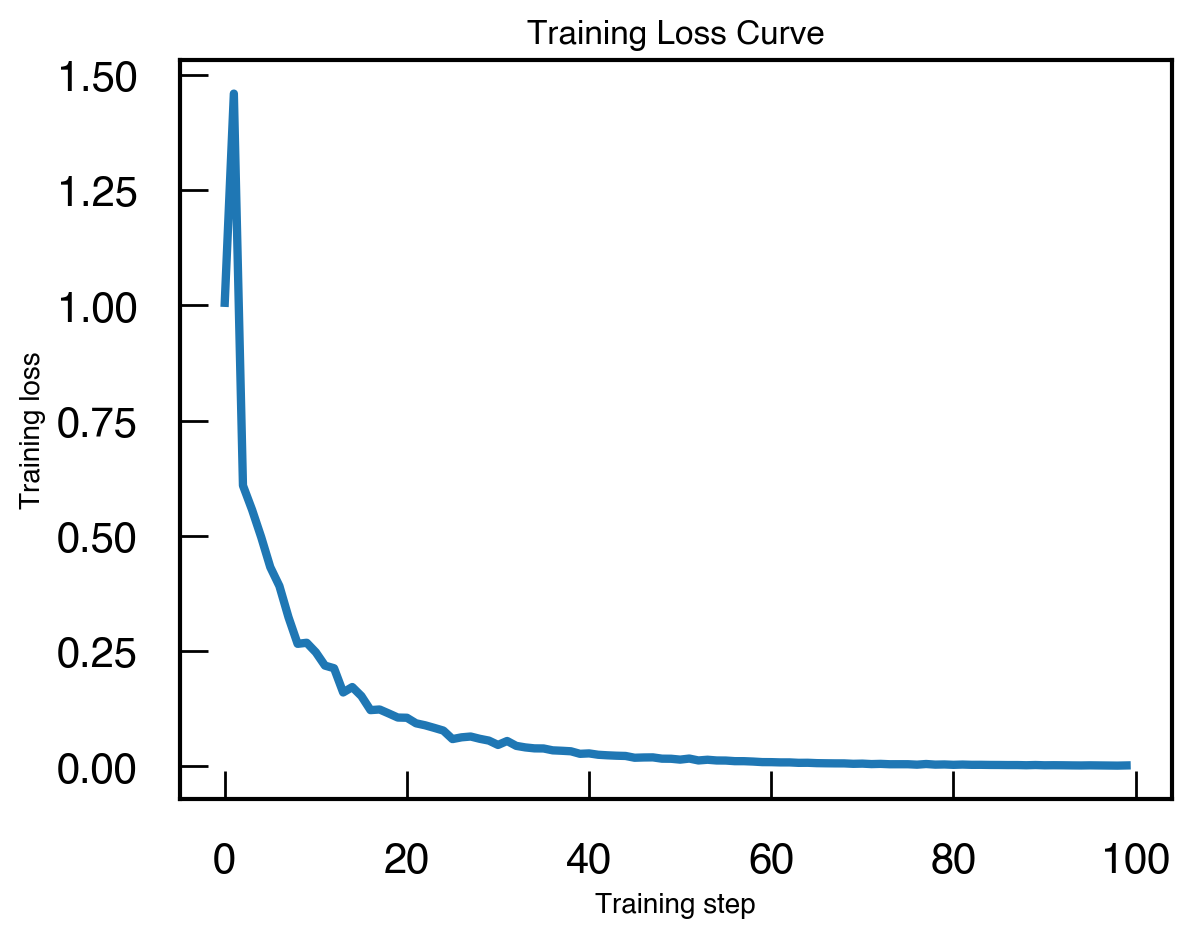

In [58]:
plt.plot(loss_callback.training_losses)
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.title('Training Loss Curve')
plt.show() 

In [59]:
mean_rmse = np.mean(all_test_rmses)
print(f"Mean RMSE: {mean_rmse}")

Mean RMSE: 0.14308985004341018


In [60]:
ref_struct = get_reference_structure()

norm_test_predictions = normalise_energies(all_test_predictions,ref_struct)
norm_test_labels = normalise_energies(all_test_labels,ref_struct)

In [61]:
def get_r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    return 1 - ss_res / ss_tot

R^2: 0.706


Text(0.5, 1.0, 'Rattling = large')

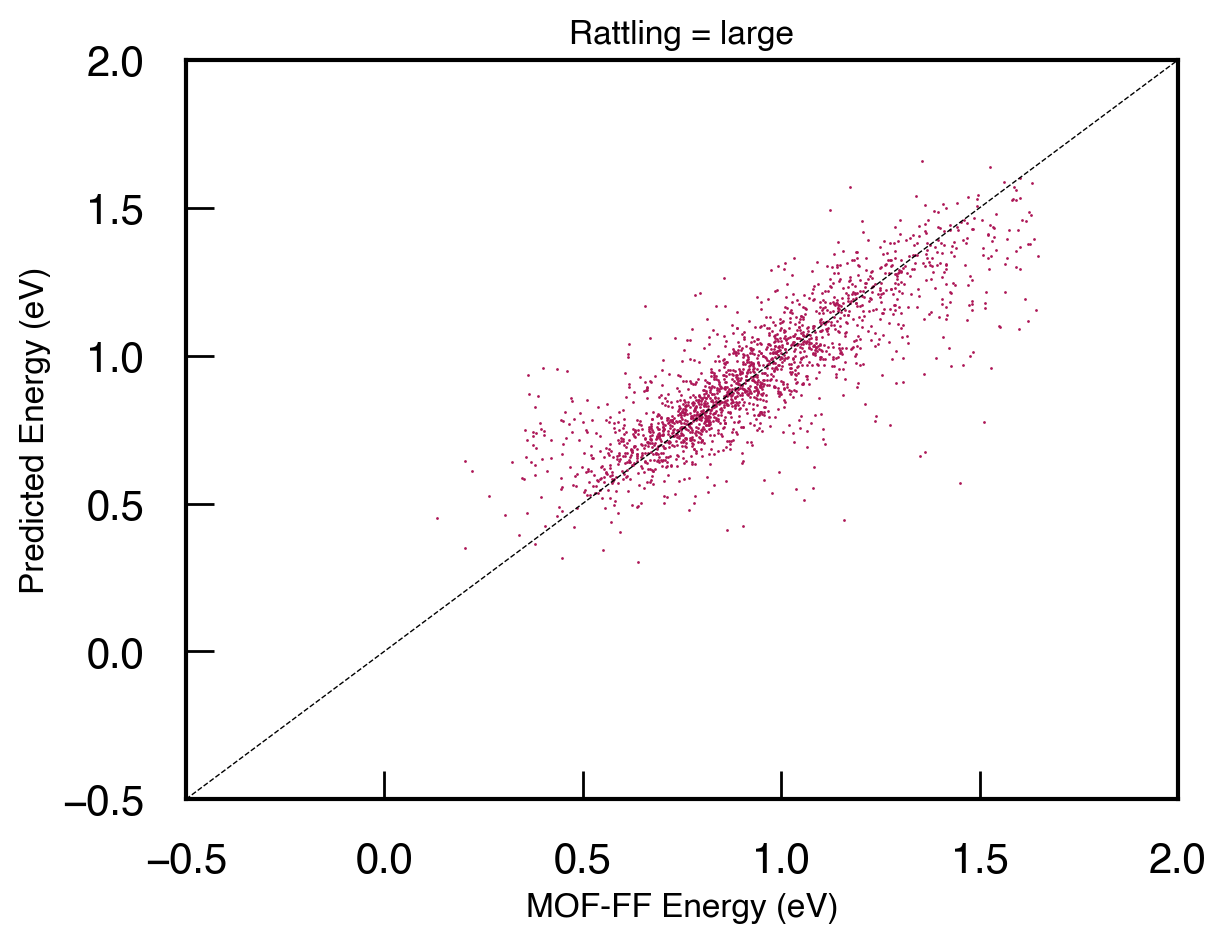

In [62]:
plt.scatter(norm_test_labels,norm_test_predictions, c='#AD1656',linewidths=0, s= 1,rasterized=True)
plt.axline((0,0),(1,1),color='k',zorder=1,linewidth=0.5,linestyle='--')
plt.xlabel('MOF-FF Energy (eV)',fontsize=12)
plt.ylabel('Predicted Energy (eV)',fontsize=12)
r_square = get_r_squared(all_test_labels,all_test_predictions)
print(f'R^2: {r_square:.3f}')
plt.xlim(-0.5,2)
plt.ylim(-0.5,2)
plt.title("Rattling = large")